In [358]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [359]:
S0 = 1.0 #Prezzo iniziale del sottostante
K = 1.0 #Prezzo di esercizio
T = 2.0 #Tempo fino alla scadenza
r = 0.001 #Tasso di interesse senza rischio
sigma = 0.4  #Volatilità
S_max = 3 * S0

In [360]:
M = 500
N = 1000

# Modello di Black-Scholes per Opzioni Digitali

Il modello di Black-Scholes è uno dei modelli più conosciuti per la valutazione dei prezzi delle opzioni europee. L'equazione differenziale parziale (EDP) di Black-Scholes per un'opzione senza pagamenti di dividendi è data da:

$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0
$$

dove:
- $V$ è il prezzo dell'opzione,
- $S$ è il prezzo dell'attivo sottostante,
- $t$ è il tempo fino alla scadenza,
- $\sigma$ è la volatilità dell'attivo sottostante,
- $r$ è il tasso di interesse privo di rischio.


# Crank-Nicolson

L'algoritmo di Crank-Nicolson è un metodo numerico per risolvere l'EDP di Black-Scholes. È un esempio di schema a differenze finite ed è noto per la sua stabilità e precisione. L'algoritmo utilizza una media tra lo schema esplicito e quello implicito di Eulero, risultando in uno schema numerico di tipo semi-implicito.

L'aggiornamento del prezzo dell'opzione dall'istante $t$ all'istante $t+\Delta t$ è dato da:

$$
A V^{n+1} = B V^n + \text{condizioni al bordo}
$$

dove $V^n$ è il vettore dei prezzi dell'opzione noti al tempo $t$ e $V^{n+1}$ è il vettore dei prezzi che si vuole calcolare per il tempo precedente $t - \Delta t$, $A$ e $B$ sono matrici che incorporano i coefficienti delle differenze finite basati sull'EDP di Black-Scholes. $V^n$ è il vettore che rappresenta i prezzi dell'opzione al tempo $t$ e $V^{n+1}$ al tempo $t + \Delta t$.


### Costruzione delle Matrici A e B

Le matrici $A$ e $B$ sono costruite come segue:

- Elementi di $A$:
  - $A_{i, i-1} = -\frac{1}{4} \Delta t (\sigma^2 i^2 - r i)$
  - $A_{i, i} = 1 + \frac{1}{2} \Delta t (\sigma^2 i^2 + r)$
  - $A_{i, i+1} = -\frac{1}{4} \Delta t (\sigma^2 i^2 + r i)$

- Elementi di $B$:
  - $B_{i, i-1} = \frac{1}{4} \Delta t (\sigma^2 i^2 - r i)$
  - $B_{i, i} = 1 - \frac{1}{2} \Delta t (\sigma^2 i^2 + r)$
  - $B_{i, i+1} = \frac{1}{4} \Delta t (\sigma^2 i^2 + r i)$

Queste matrici sono utilizzate per calcolare il prezzo dell'opzione a ogni passo temporale, risolvendo il sistema lineare per ottenere $V^{n+1}$ da $V^n$.


### Condizioni al Contorno

Le condizioni al contorno sono essenziali per la corretta implementazione dell'algoritmo di Crank-Nicolson. In questo caso, per un'opzione digitale, le condizioni al contorno riflettono il payoff dell'opzione a scadenza, che è 1 se $S < K$ o 0 altrimenti.

Le condizioni al contorno per i bordi della griglia computazionale sono impostate come segue:
- Per $S=0$, il prezzo dell'opzione è sempre 0, poiché il sottostante non ha valore.
- Per $S$ molto grande, il prezzo dell'opzione tende a 0 per un'opzione di vendita digitale, poiché la probabilità che il sottostante sia sotto il prezzo di esercizio è trascurabile.

Queste condizioni sono implementate nel codice attraverso l'aggiornamento dei vettori prima della risoluzione del sistema lineare ad ogni passo temporale.


Questa funzione `crank_nicolson` calcola il prezzo di un'opzione digitale utilizzando il metodo di Crank-Nicolson per risolvere l'equazione differenziale parziale di Black-Scholes. `M` rappresenta il numero di passi temporali, mentre `N` indica il numero di passi spaziali nella discretizzazione del modello.

$$ \frac{V_i^{n+1} - V_i^n}{\Delta t} = \frac{1}{2} \left[ \mathcal{L}(V_i^{n+1}) + \mathcal{L}(V_i^n) \right] $$

L'implementazione in codice dell'algoritmo di Crank-Nicolson utilizza le matrici $A$ e $B$ per calcolare i prezzi dell'opzione a ogni passo temporale. Il codice costruisce queste matrici basandosi sulle dimensioni della griglia di discretizzazione sia nel tempo ($M$) che nello spazio ($N$). 

Per risolvere il sistema lineare ad ogni passo temporale all'indietro (dal tempo finale al tempo iniziale), utilizziamo la funzione `numpy.linalg.solve`, che trova la soluzione del sistema lineare $Ax = B$.

Infine, utilizziamo la funzione `numpy.interp` per interpolare i risultati della griglia discretizzata e ottenere un'approssimazione del prezzo dell'opzione al prezzo del sottostante corrente $S_0$.


In [361]:
def crank_nicolson(M, N):
    dt = T / M
    S = np.linspace(0, S_max, N+1)

    A = np.zeros((N+1, N+1))
    B = np.zeros((N+1, N+1))
    V = np.where(S <= K, 1, 0)

    for i in range(1, N):
        a = 0.25 * dt * (sigma**2 * i**2 - r * i)
        b = -0.5 * dt * (sigma**2 * i**2 + r)
        c = 0.25 * dt * (sigma**2 * i**2 + r * i)

        A[i, i-1] = -a
        A[i, i] = 1 - b
        A[i, i+1] = -c

        B[i, i-1] = a
        B[i, i] = 1 + b
        B[i, i+1] = c

    A[0, 0] = A[N, N] = 1
    B[0, 0] = B[N, N] = 1

    for j in range(M):
        V = np.linalg.solve(A, B.dot(V))
        V[0] = 1
        V[N] = 0

    # la funzione np.interp ci serve per interpolare il prezzo dell'opzione al prezzo iniziale del sottostante S0.
    return np.interp(S0, S, V), S, V

In [362]:
crank_nicolson(M, N)[0]

0.6090624927277373

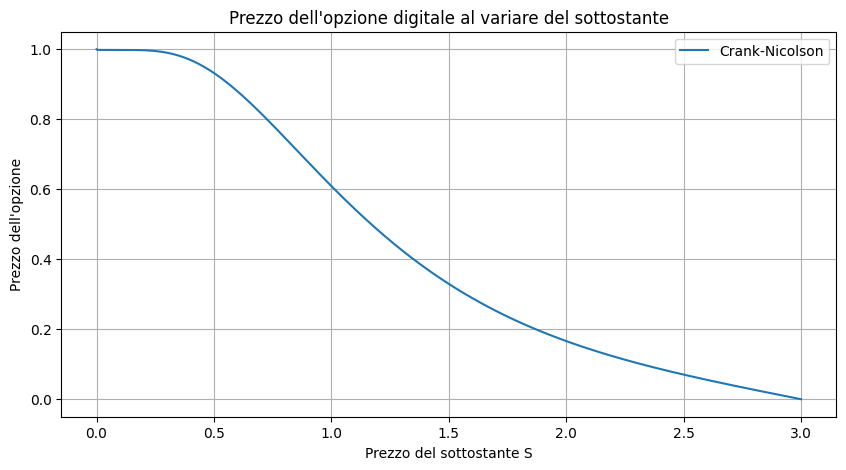

In [363]:
V_interpol, S, V = crank_nicolson(M, N)

plt.figure(figsize=(10, 5))
plt.plot(S, V, label='Crank-Nicolson')
plt.title("Prezzo dell'opzione digitale al variare del sottostante")
plt.xlabel('Prezzo del sottostante S')
plt.ylabel('Prezzo dell\'opzione')
plt.legend()
plt.grid(True)
plt.show()

### Convergenza dell'Algoritmo

L'algoritmo di Crank-N
icolson è noto per la sua convergenza e stabilità, soprattutto se confrontato con metodi puramente espliciti o impliciti. La convergenza dell'algoritmo è garantita sotto certe condizioni, che nel contesto delle EDP finanziarie sono generalmente soddisfatte se si utilizzano passi di discretizzazione adeguati nel tempo ($\Delta t$) e nello spazio ($\Delta S$).

In questa sezione del codice, eseguiamo la funzione di calcolo del prezzo per una serie di valori di `M` e `N`. Questo ci permette di osservare come il prezzo dell'opzione varia al cambiare della risoluzione della griglia temporale e spaziale e di verificare la convergenza del modello.


In [364]:
# M_values = [50, 200, 500, 1000 ]
# N_values = [50, 200, 500, 1000]
M_values = [50, 200, 500, 800, 1000, 2000]
N_values = [50, 200, 500, 800, 1000, 2000]

In [365]:
conf_crank_nicolson = []
conf_crank_nicolson_grafico = []

# Calcolo prezzo e salvare risultato
for M in M_values:
    for N in N_values:
        prezzo = crank_nicolson(M, N)[0]
        conf_crank_nicolson.append((M, N, prezzo))
        conf_crank_nicolson_grafico.append((M, N, prezzo))
        print(f"Per M={M}, N={N}, il prezzo dell'opzione digitale è: {prezzo}")

Per M=50, N=50, il prezzo dell'opzione digitale è: 0.6020258482171883
Per M=50, N=200, il prezzo dell'opzione digitale è: 0.6055989539593429
Per M=50, N=500, il prezzo dell'opzione digitale è: 0.5593119100198127
Per M=50, N=800, il prezzo dell'opzione digitale è: 0.5231371484815248
Per M=50, N=1000, il prezzo dell'opzione digitale è: 0.7077853511237507
Per M=50, N=2000, il prezzo dell'opzione digitale è: 0.47617505370100643
Per M=200, N=50, il prezzo dell'opzione digitale è: 0.6020244033539668
Per M=200, N=200, il prezzo dell'opzione digitale è: 0.6070370659598373
Per M=200, N=500, il prezzo dell'opzione digitale è: 0.608044305459636
Per M=200, N=800, il prezzo dell'opzione digitale è: 0.6069397034770596
Per M=200, N=1000, il prezzo dell'opzione digitale è: 0.6146446254560067
Per M=200, N=2000, il prezzo dell'opzione digitale è: 0.5602647085378873
Per M=500, N=50, il prezzo dell'opzione digitale è: 0.60202432242957
Per M=500, N=200, il prezzo dell'opzione digitale è: 0.6070370028925175

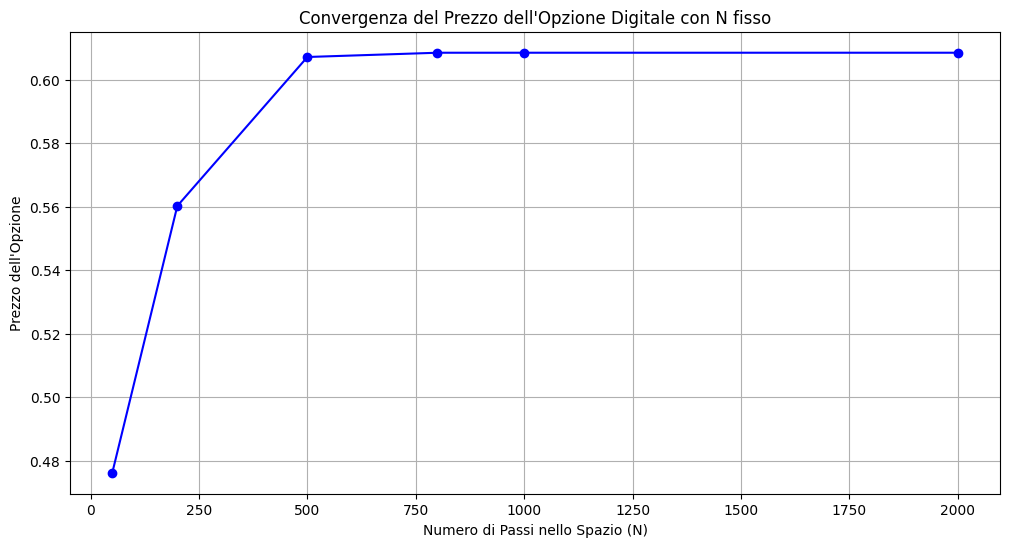

In [366]:
N_fisso = N
prezzi_convergenza = [crank_nicolson(M, N_fisso)[0] for M in M_values]

plt.figure(figsize=(12, 6))
plt.plot(M_values, prezzi_convergenza, marker='o', linestyle='-', color='b')
plt.title('Convergenza del Prezzo dell\'Opzione Digitale con N fisso')
plt.xlabel('Numero di Passi nello Spazio (N)')
plt.ylabel('Prezzo dell\'Opzione')
plt.grid(True)
plt.show()


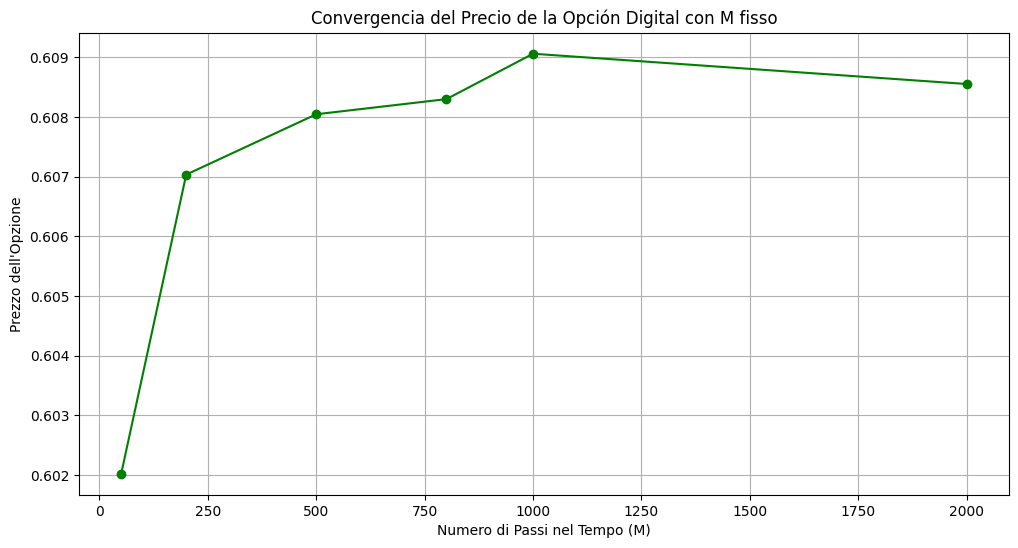

In [367]:
M_fisso = M
prezzi_convergenza = [crank_nicolson(M_fisso, N)[0] for N in N_values]

plt.figure(figsize=(12, 6))
plt.plot(N_values, prezzi_convergenza, marker='o', linestyle='-', color='g')
plt.title('Convergencia del Precio de la Opción Digital con M fisso')
plt.xlabel('Numero di Passi nel Tempo (M)')
plt.ylabel('Prezzo dell\'Opzione')
plt.grid(True)
plt.show()


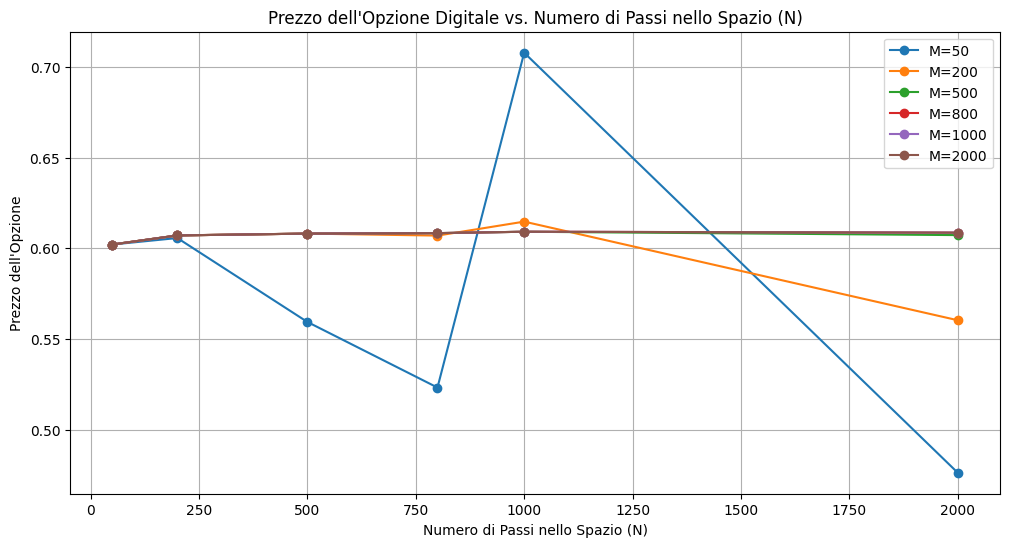

In [368]:
# Preparare i dati per il grafico
prezzi_per_M = {M: [] for M in M_values}
for prezzo in conf_crank_nicolson:
    M, N, prezzo_opzione = prezzo
    prezzi_per_M[M].append(prezzo_opzione)

# Grafico del prezzo dell'opzione vs. numero di passi nello spazio (N)
plt.figure(figsize=(12, 6))
for M, conf_crank_nicolson in prezzi_per_M.items():
    plt.plot(N_values, conf_crank_nicolson, marker='o', label=f'M={M}')
    
plt.title('Prezzo dell\'Opzione Digitale vs. Numero di Passi nello Spazio (N)')
plt.xlabel('Numero di Passi nello Spazio (N)')
plt.ylabel('Prezzo dell\'Opzione')
plt.legend()
plt.grid(True)
plt.show()


---

# Algoritmo di Eulero Implicito

L'algoritmo di Eulero implicito è un metodo numerico per la risoluzione di equazioni differenziali parziali che utilizza valori al tempo futuro per garantire la stabilità del metodo. La formulazione per il metodo di Eulero implicito è data da:

$$
\frac{V^{n+1} - V^n}{\Delta t} = \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V^{n+1}}{\partial S^2} + rS\frac{\partial V^{n+1}}{\partial S} - rV^{n+1}
$$

La matrice per l'algoritmo di Eulero implicito può essere scritta come:

$$
(I - \Delta t \cdot L)V^{n+1} = V^n
$$

dove $L$ è l'operatore differenziale che include i termini di derivate seconde e prime rispetto a $S$ e il termine di deriva zero (termine senza derivata).


In [369]:
def eulero_implicito(M, N):
    dt = T / M
    S = np.linspace(0, S_max, N + 1)
    V = np.where(S < K, 1, 0)
    
    # Inizializzazione della matrice tridiagonale per l'algoritmo di Eulero implicito
    A = np.zeros((N+1, N+1))
    for i in range(1, N):
        A[i, i-1] = 0.5 * dt * (r * i - sigma**2 * i**2)
        A[i, i] = 1 + dt * (sigma**2 * i**2 + r)
        A[i, i+1] = -0.5 * dt * (sigma**2 * i**2 + r * i)
    
    # Condizioni al contorno
    A[0, 0] = 1
    A[N, N] = 1
    V[0] = 1  # Il prezzo dell'opzione è 1 se S=0, assumendo che S<K
    V[N] = 0  # Il prezzo dell'opzione è 0 se S è molto grande
    
    # Ciclo temporale attraverso i passi di Eulero implicito
    for j in range(M):
        V = np.linalg.solve(A, V)
    
    # Interpolazione per trovare il valore al prezzo iniziale S0
    return np.interp(S0, S, V), S, V

In [370]:
prezzo_opzione_eulero = eulero_implicito(M, N)[0]
print("Prezzo dell'opzione digitale con Eulero Implicito:", prezzo_opzione_eulero)

Prezzo dell'opzione digitale con Eulero Implicito: 0.6085469897531894


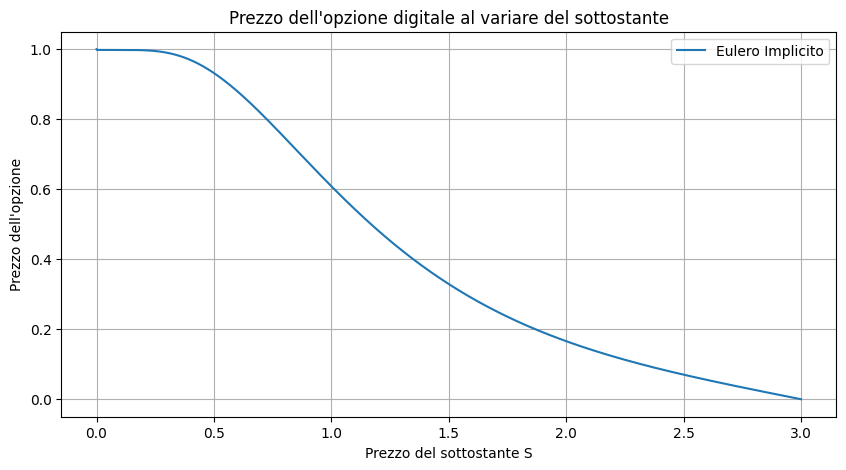

In [371]:
V_interpol, S, V = eulero_implicito(M, N)

plt.figure(figsize=(10, 5))
plt.plot(S, V, label='Eulero Implicito')
plt.title("Prezzo dell'opzione digitale al variare del sottostante")
plt.xlabel('Prezzo del sottostante S')
plt.ylabel('Prezzo dell\'opzione')
plt.legend()
plt.grid(True)
plt.show()

### Convergenza dell'algoritmo

In [372]:
conf_eulero_implicito = []
conf_eulero_implicito_grafico = []

# Calcolo prezzo e salvare risultato
for M in M_values:
    for N in N_values:
        prezzo = eulero_implicito(M, N)[0]
        conf_eulero_implicito.append((M, N, prezzo))
        conf_eulero_implicito_grafico.append((M, N, prezzo))
        print(f"Per M={M}, N={N}, il prezzo dell'opzione digitale è: {prezzo}")

Per M=50, N=50, il prezzo dell'opzione digitale è: 0.60165427623263
Per M=50, N=200, il prezzo dell'opzione digitale è: 0.6067066049222413
Per M=50, N=500, il prezzo dell'opzione digitale è: 0.6077257149474768
Per M=50, N=800, il prezzo dell'opzione digitale è: 0.607980976230932
Per M=50, N=1000, il prezzo dell'opzione digitale è: 0.6087479502896317
Per M=50, N=2000, il prezzo dell'opzione digitale è: 0.6082364346384833
Per M=200, N=50, il prezzo dell'opzione digitale è: 0.6019321203228241
Per M=200, N=200, il prezzo dell'opzione digitale è: 0.6069546402229643
Per M=200, N=500, il prezzo dell'opzione digitale è: 0.6079677883542882
Per M=200, N=800, il prezzo dell'opzione digitale è: 0.6082215576170255
Per M=200, N=1000, il prezzo dell'opzione digitale è: 0.6089840506185064
Per M=200, N=2000, il prezzo dell'opzione digitale è: 0.6084755232258695
Per M=500, N=50, il prezzo dell'opzione digitale è: 0.6019874592851913
Per M=500, N=200, il prezzo dell'opzione digitale è: 0.607004071653799
P

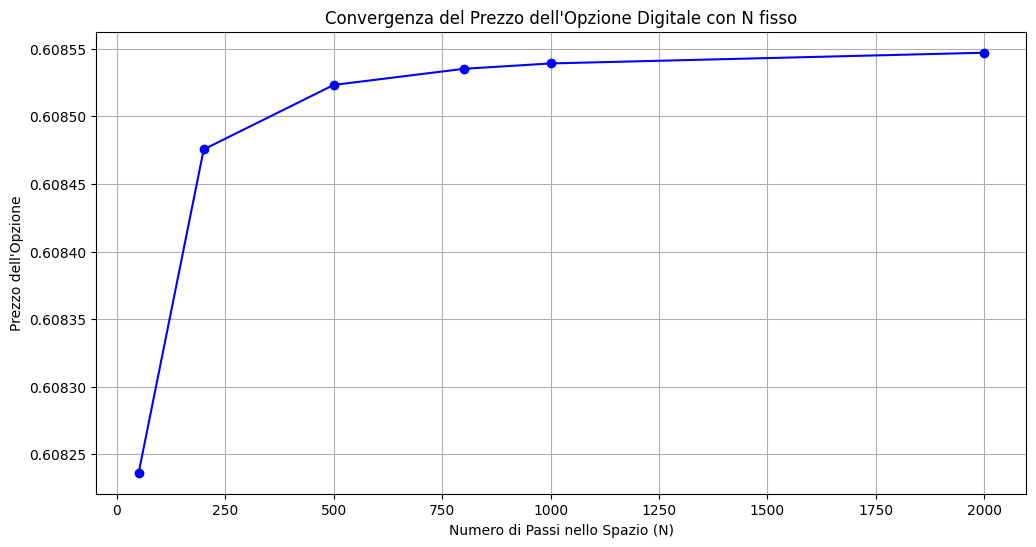

In [373]:
N_fisso = N
prezzi_convergenza = [eulero_implicito(M, N_fisso)[0] for M in M_values]

plt.figure(figsize=(12, 6))
plt.plot(M_values, prezzi_convergenza, marker='o', linestyle='-', color='b')
plt.title('Convergenza del Prezzo dell\'Opzione Digitale con N fisso')
plt.xlabel('Numero di Passi nello Spazio (N)')
plt.ylabel('Prezzo dell\'Opzione')
plt.grid(True)
plt.show()


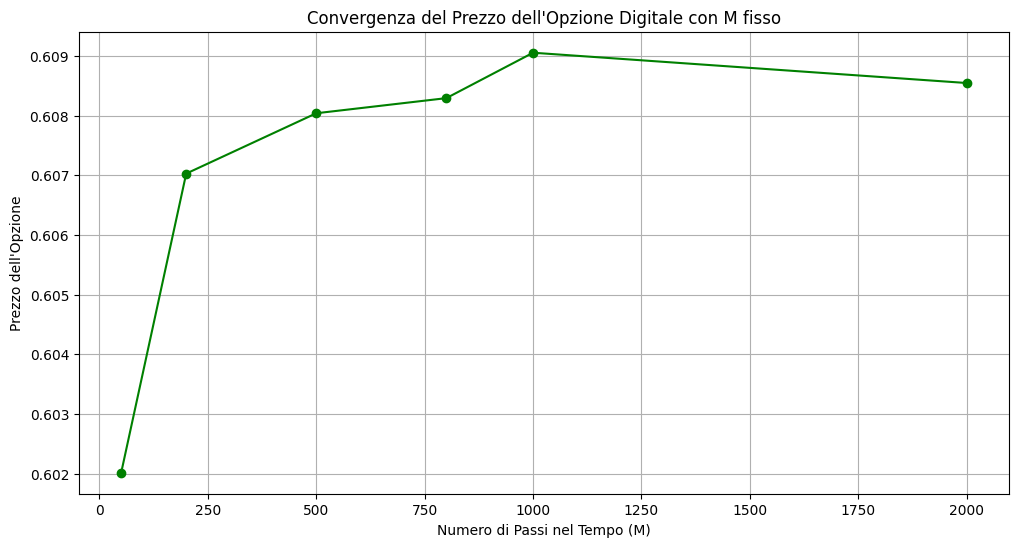

In [374]:
M_fisso = M
prezzi_convergenza = [eulero_implicito(M_fisso, N)[0] for N in N_values]

plt.figure(figsize=(12, 6))
plt.plot(N_values, prezzi_convergenza, marker='o', linestyle='-', color='g')
plt.title('Convergenza del Prezzo dell\'Opzione Digitale con M fisso')
plt.xlabel('Numero di Passi nel Tempo (M)')
plt.ylabel('Prezzo dell\'Opzione')
plt.grid(True)
plt.show()


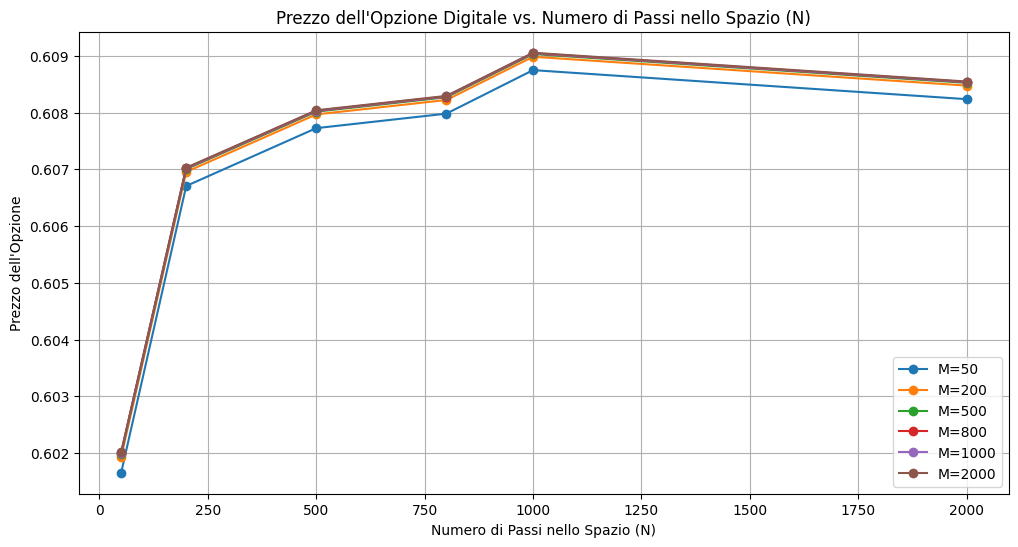

In [375]:
# Preparare i dati per il grafico
prezzi_per_M = {M: [] for M in M_values}
for prezzo in conf_eulero_implicito:
    M, N, prezzo_opzione = prezzo
    prezzi_per_M[M].append(prezzo_opzione)

# Grafico del prezzo dell'opzione vs. numero di passi nello spazio (N)
plt.figure(figsize=(12, 6))
for M, conf_eulero_implicito in prezzi_per_M.items():
    plt.plot(N_values, conf_eulero_implicito, marker='o', label=f'M={M}')
    
plt.title('Prezzo dell\'Opzione Digitale vs. Numero di Passi nello Spazio (N)')
plt.xlabel('Numero di Passi nello Spazio (N)')
plt.ylabel('Prezzo dell\'Opzione')
plt.legend()
plt.grid(True)
plt.show()


---

# Comparazione convergenza

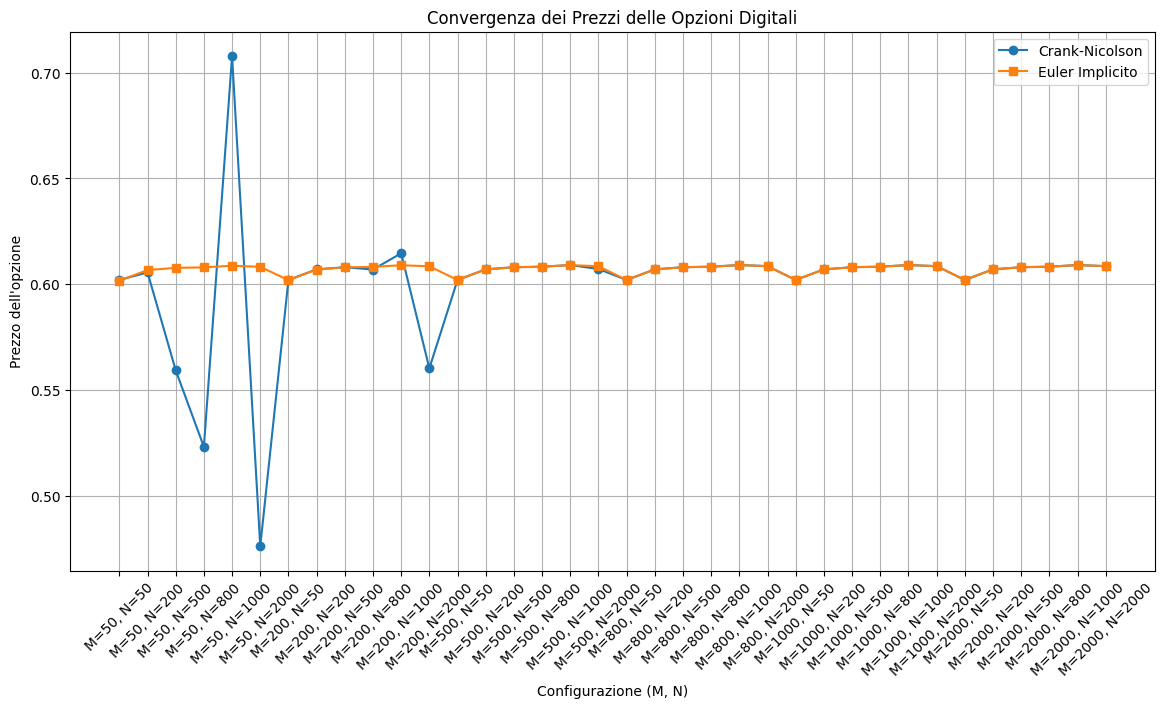

In [376]:
prezzi_crank_nicolson =  []
prezzi_euler_implicito = []
M_N_values = []

for prezzo in conf_crank_nicolson_grafico:
    M, N, prezzo_opzione = prezzo
    prezzi_crank_nicolson.append(prezzo_opzione)
    M_N_values.append([M,N])


for prezzo in conf_eulero_implicito_grafico:
    M, N, prezzo_opzione = prezzo
    prezzi_euler_implicito.append(prezzo_opzione)


plt.figure(figsize=(14, 7))

plt.plot(range(len(prezzi_crank_nicolson)), prezzi_crank_nicolson, '-o', label='Crank-Nicolson')
plt.plot(range(len(prezzi_euler_implicito)), prezzi_euler_implicito, '-s', label='Euler Implicito')

plt.xlabel('Configurazione (M, N)')
plt.ylabel("Prezzo dell'opzione")
plt.title('Convergenza dei Prezzi delle Opzioni Digitali')
plt.xticks(range(len(prezzi_crank_nicolson)), [f"M={M}, N={N}" for M, N in M_N_values], rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [377]:
prezzi_tutti_modelli = []
for i in zip(M_N_values, prezzi_crank_nicolson, prezzi_euler_implicito):
    prezzi_tutti_modelli.append(i)

df = pd.DataFrame(prezzi_tutti_modelli, columns=['M, N', 'Crank-Nicolson', 'Eulero Implicito'])
df = df.style.set_caption('Prezzo opzione digitale')
df

,"M, N",Crank-Nicolson,Eulero Implicito
0,"[50, 50]",0.602026,0.601654
1,"[50, 200]",0.605599,0.606707
2,"[50, 500]",0.559312,0.607726
3,"[50, 800]",0.523137,0.607981
4,"[50, 1000]",0.707785,0.608748
5,"[50, 2000]",0.476175,0.608236
6,"[200, 50]",0.602024,0.601932
7,"[200, 200]",0.607037,0.606955
8,"[200, 500]",0.608044,0.607968
9,"[200, 800]",0.606940,0.608222


---

# Check Black & Scholes

Per sicurezza, è stato effettuato un controllo con Black&Scholes, da cui si evince che l'algoritmo di Crank-Nicolson e quello di Eulero Implicito sono stati implementati correttamente, in quanto i prezzi convergono a quelli di B&S.

Con un'opzione put digitale, il payoff è 1 quando \( S < K \), e per ottenere il prezzo dell'opzione digitale dal modello di Black-Scholes, si considera la probabilità che \( S \) sia inferiore a \( K \) al momento della scadenza. Tuttavia, il modello classico di Black-Scholes fornisce direttamente il prezzo per le opzioni vanilla (call e put), non per le opzioni digitali.

Per le opzioni digitali, si può usare una formula derivata dal modello di Black-Scholes che considera il valore scontato della probabilità che l'opzione finisca "in the money". Per un'opzione put digitale, il prezzo può essere calcolato come:

$$
\text{Prezzo opzione digitale put} = e^{-rT} \Phi(-d_2)
$$

dove:
- $e^{-rT}$ è il fattore di sconto esponenziale,
- $\Phi$ è la funzione di distribuzione cumulativa della normale standard,
- $d_2$ = $\frac{\ln(S_0 / K) + (r - \frac{1}{2} \sigma^2) T}{\sigma \sqrt{T}}$

In [378]:
def black_scholes(S0, K, T, r, sigma):
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    prezzo_put_digitale = np.exp(-r * T) * norm.cdf(-d2)

    return prezzo_put_digitale

In [379]:
prezzo_put_digitale_BS = black_scholes(S0, K, T, r, sigma)
print("Prezzo dell'opzione put digitale con Black&Scholes:", prezzo_put_digitale_BS)

Prezzo dell'opzione put digitale con Black&Scholes: 0.6087766794122874
